## DEMO - Training eines CNN

Verwendung in der Projektphase 2

Das Notebook zeigt beispielhaft die Durchführung folgender Schritte mit Keras:
- Vorverarbeitungsschritte der Bilder
- Trainieren eines CNNs
- Speichern und Laden
- Anwendung
- Transformation in ein TF-lite-Modell

Die verwendeten Bilder müsen sich im Ordner `/gitignore/data/images` befinden.

In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2

### Laden und Inspektion der Trainingsbilder

In [2]:
# Lesen der Filenamen der Bilder in einem Ordner 
from os import listdir,path
img_path = './gitignore/data/images/'
img_files = listdir(img_path)
len(img_files) , len(set(img_files))

(607, 607)

(480, 640, 3)


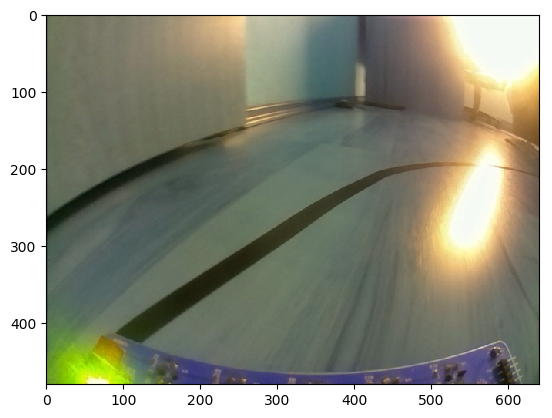

In [3]:
# Ansicht eines Beispielbildes (rot grün vertauscht)
img_example = cv2.imread(img_path + img_files[10])
plt.imshow(img_example)
print(img_example.shape)

In [4]:
# Einlesen aller Bilder -> Kontrolle der Anzahl
imgs = np.array([cv2.imread(img_path+i) for i in img_files])
imgs.shape

(607, 480, 640, 3)

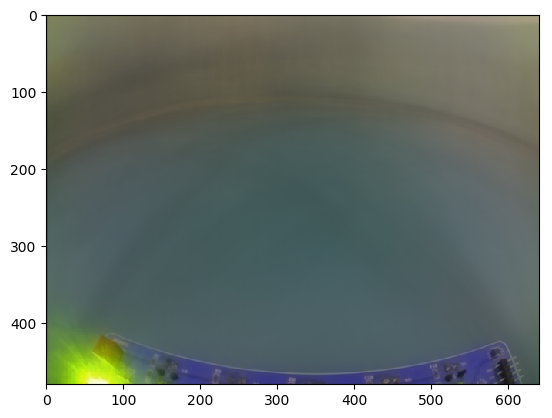

In [5]:
# Mittleres Bilder der Trainingsbilder
img_mean = imgs.mean(axis=0).astype('int')
plt.imshow(img_mean)

### Vorverarbeitung der Bilder

Im Folgenden werden verschiedene Vorverarbeitugnsschritte durchgeführt:
- Änderungen der Größe/Auflösung des Bildes
- Konvertierung zur Schwarz/Weiß
- Suchen und Verwenden eines geeigneten Bildausschnittes

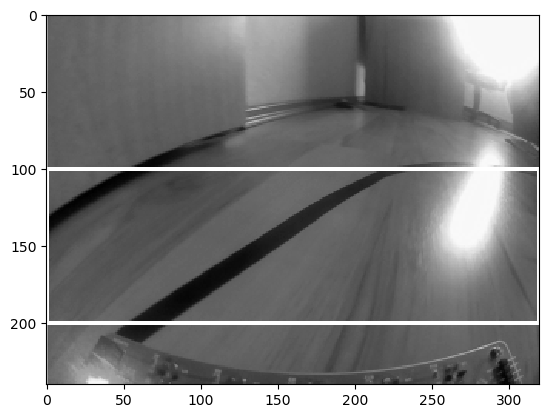

In [6]:
# Testweise Bildbearbeitung
sp=(0,200)
ep=(320,100)
dim = (320,240)
interpolation = cv2.INTER_AREA
img_example_x = img_example.copy()
img_example_x = cv2.cvtColor(img_example_x,cv2.COLOR_BGR2GRAY)
img_example_x= cv2.resize(img_example_x,dim,interpolation)
#plt.imshow(img_example_x)
plt.imshow(cv2.rectangle(img_example_x,sp,ep,(255,255,0),2),cmap='gray')

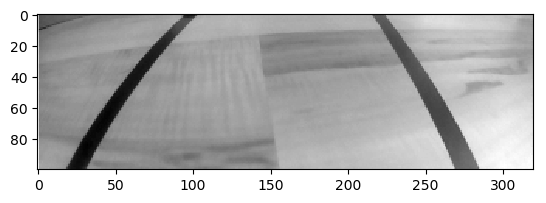

In [7]:
# Definition einer Funktion zur Vorverarbeitung eines einzelnen Trainingsbildes
# Dieser Verarbeitungsschritte müssen bei der Anwendungung des neuronlen Netzes
# am RPi ebenfalls in identischer Form durchgeführt werden.
def transform_image(img):
    dim = (320,240)
    interpolation = cv2.INTER_AREA
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # Verwendung von Graustufenbildern
    img = cv2.resize(img,dim,interpolation) #  Anpassung der Bildgröße
    img = img[100:200,:] # Ausschneiden eines Teilbildes
    return img

plt.imshow(transform_image(imgs[0]),cmap='gray')

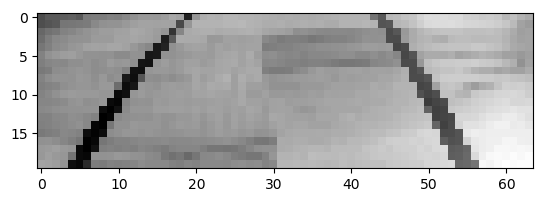

In [8]:
# Alternative mit Verkleinerung der Bilder
# Definition einer Funktion zur Vorverarbeitung der Trainingsbilder
def transform_image_small(img):
    dim = (64,48)
    interpolation = cv2.INTER_AREA
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # Verwendung von Graustufenbildern
    img = cv2.resize(img,dim,interpolation) #  Anpassung der Bildgröße
    #img = img[100:200,:] # Ausschneiden eines Teilbildes
    img = img[20:40,:] # Ausschneiden eines Teilbildes
    return img

plt.imshow(transform_image_small(imgs[0]),cmap='gray')

In [9]:
# Laden und Vorverarbeiten aller Trainingsbilder (groß)
imgs_large = np.array([transform_image(cv2.imread(img_path+i)) for i in img_files])
imgs_large.shape

(607, 100, 320)

In [10]:
imgs_small = np.array([transform_image_small(cv2.imread(img_path+i)) for i in img_files])
imgs_small.shape

(607, 20, 64)

### Laden der Lenkwinkel

In [11]:
# Position des Lenkwinkels im Filenamen (abhängig von gewählter Vorgehensweise)
x = img_files[0]
print(x)
print('-',x[46:-4],'-') # Raspberry/Linux
print('-',x[50:-4],'-') # Windows


IMG_DMRC_2e33ee13_20220703_16:10:16_0197_S22_A75.jpg
- 75 -
-  -


In [12]:
angles = np.array([int(i[46:-4]) for i in img_files]) # Extrahieren der Lenkwinkel aus dem Dateinamen

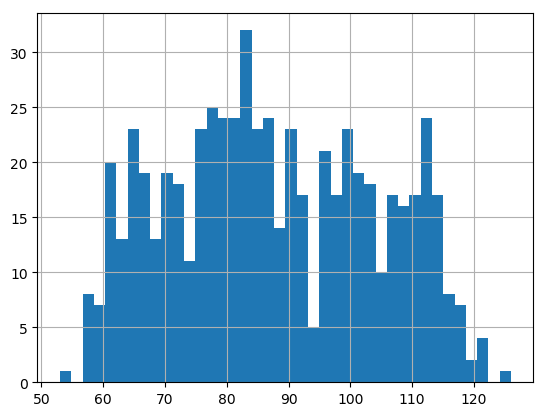

In [13]:
# Betrachtung der Verteilung der Lenkwinkel in den Trainingsdaten
# -> typischerweise nicht symmetrisch
pd.Series(angles, name ='angles').hist(bins = 40)

### Spiegeln der Bilder (Augmentation)

Das Spiegeln der Bilder erhöht bzw. verdoppelt die Anzahle der Trainingsdaten und sorgt für ein ausgeglichenes Verhältnis von Rechts- und Linkskurven!

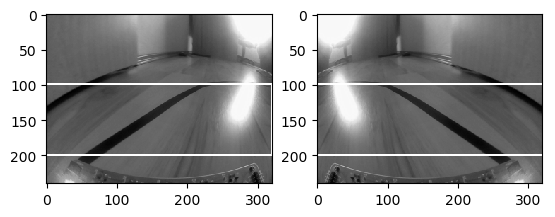

In [14]:
# Test Spiegeln eines Bildes
img_example_x_mirrored = img_example_x[:,::-1] # alternativ mit cv2.flip
plt.figure()
plt.subplot(121)
plt.imshow(img_example_x,cmap='gray')
plt.subplot(122)
plt.imshow(img_example_x_mirrored,cmap='gray')

In [15]:
# Spiegeln und Zusammenfügen der ungespiegelten und der gespiegelten Trainingsbilder
# Große Bilder
imgs_large_mirrored = imgs_large[:,:,::-1]
print(imgs_large.shape)
print(imgs_large_mirrored.shape)
imgs_large_all = np.concatenate((imgs_large,imgs_large_mirrored))
print(imgs_large_all.shape)

(607, 100, 320)
(607, 100, 320)
(1214, 100, 320)


In [16]:
# Zusammenfügen der ungespiegelten und der gespiegelten Trainingsbilder
# Kleine Bilder
imgs_small_mirrored = imgs_small[:,:,::-1]
print(imgs_small.shape)
print(imgs_small_mirrored.shape)
imgs_small_all = np.concatenate((imgs_small,imgs_small_mirrored))
print(imgs_small_all.shape)

(607, 20, 64)
(607, 20, 64)
(1214, 20, 64)


### "Spiegeln" der Lenkwinkel (Agumentation)
- inklusive des Ladens/Extrahierens der Lenkwinkel aus den Dateinamen

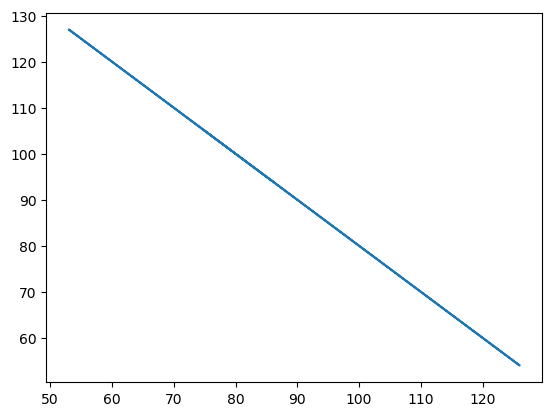

In [17]:
angles_mirrored = [-a+180 for a in angles] # Spiegeln der Winkel

# Kontrolle
plt.plot(angles,angles_mirrored)
angles_all = np.hstack((angles,angles_mirrored)) # Zusammenführen der ungespiegelten und gespiegelten Winkel

In [18]:
angles_all

array([75, 98, 80, ..., 94, 80, 94])

### Verteilung der Lenkwinkel im gesamten Trainingset

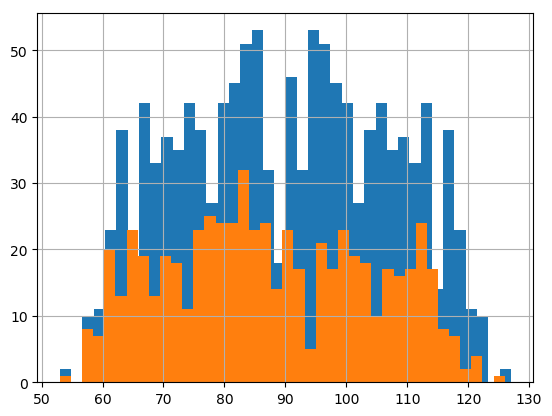

In [19]:
pd.Series(angles_all, name ='angles').hist(bins = 40)
pd.Series(angles, name ='angles').hist(bins = 40)

### Erstellen des NN  mit Tensorflow

In [25]:
# Import notwendiger Klassen und Funktionen
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout
from tensorflow.keras.optimizers import Adam

In [23]:
# Die Trainingsdaten sollen eine Shape erhalten, welche die Farbkanäle berücksichtigen...
# ... auch wenn in diesem Beispiele nur ein Farbkanal vorhanden ist.
n,h,w = imgs_large_all.shape
imgs_large_all_tf = imgs_large_all.reshape((n,h,w,1))
n,h,w,f = imgs_large_all_tf.shape
input_shape = (h,w,f)
print(input_shape)

(100, 320, 1)


In [26]:
# Erstellen des Netzes für die großen Bilder
# Keras Sequntial API
model = tf.keras.Sequential(name='dnn') 

# Convolution Layers 
# elu: Expenential Linear Unit, similar to leaky Relu 
model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=input_shape, activation='elu')) 
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu')) 
model.add(Dropout(0.2)) # more robustness 
model.add(Conv2D(64, (3, 3), activation='elu')) 

# Fully Connected Layers 
model.add(Flatten()) 
model.add(Dropout(0.2)) # more robustness 
model.add(Dense(100, activation='elu')) 
model.add(Dense(50, activation='elu')) 
model.add(Dense(10, activation='elu'))

# Output Layer: turning angle
model.add(Dense(1)) 


In [27]:
model.summary()

Model: "dnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 158, 24)       624       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 77, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 37, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 35, 64)         27712     
_________________________________________________________________
dropout (Dropout)            (None, 7, 35, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 33, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 10560)             0       

In [352]:
# Die Trainingsdaten sollen eine Shape erhalten, welche die Farbkanäle berücksichtigen...
# ... auch wenn in diesem Beispiele nur ein Farbkanal vorhanden ist.
# Alternative für kleines Bild
n,h,w = imgs_small_all.shape
imgs_small_all_tf = imgs_small_all.reshape((n,h,w,1))
n,h,w,f = imgs_small_all_tf.shape
input_shape_small = (h,w,f)
print(input_shape_small)

(20, 64, 1)


In [465]:
# Alternative für kleinens Bild und normales NN
model_small = tf.keras.Sequential(name='dnn_dense') 

# Convolution Layers 
# elu: Expenential Linear Unit, similar to leaky Relu 
model_small.add(Conv2D(10, (2, 6), strides=(2, 3), input_shape=input_shape_small, activation='elu')) 
model_small.add(Conv2D(10, (2, 5), strides=(2, 2), activation='elu'))
model_small.add(Conv2D(10, (2, 4), strides=(2, 2), activation='elu'))
model_small.add(Conv2D(20, (2, 2), strides=(2, 2), activation='elu'))
# Fully Connected Layers 
model_small.add(Flatten()) 
#model_small.add(Dropout(0.2)) # more robustness 
#model_small.add(Dense(20, activation='elu')) 
model_small.add(Dense(10, activation='elu')) 
model_small.add(Dense(10, activation='elu')) 

# Output Layer: turning angle
model_small.add(Dense(1))

In [466]:
n,h,w = imgs_small_all.shape
print(imgs_small_all.shape)
imgs_small_all_tf_flat = imgs_small_all.reshape((n,h*w))
imgs_small_all_tf_flat.shape

(1214, 20, 64)


(1214, 1280)

In [467]:
# Alternative für kleinens Bild
# Erstellen des Netzes für das stark verkleinert Bild
# Die Größte des Netzes muss angepasst werden. (Anzahl der Schichten, Kernelsizes, Strides)
model_small_flat = tf.keras.Sequential(name='dnn_small') 
model_small_flat.add(Dense(100, input_shape=(imgs_small_all_tf_flat.shape), activation='elu')) 
model_small_flat.add(Dense(20, activation='elu')) 

# Output Layer: turning angle
model_small_flat.add(Dense(1))

In [468]:
# Kontrolle der Architektur
# Das kleine Modell hat bedeuteten weniger Parameter
model_small_flat.summary()

Model: "dnn_small"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_255 (Dense)            (None, 1214, 100)         128100    
_________________________________________________________________
dense_256 (Dense)            (None, 1214, 20)          2020      
_________________________________________________________________
dense_257 (Dense)            (None, 1214, 1)           21        
Total params: 130,141
Trainable params: 130,141
Non-trainable params: 0
_________________________________________________________________


### Auswahl der Bilder bzw. des Modells (große oder kleine Bilder)

In [469]:
# Auswahl der großen oder kleinen Bilder und des zugehörigen Modells
#imgs_all_tf= imgs_small_all_tf_flat
#model = model_small_flat
imgs_all_tf= imgs_small_all_tf
model = model_small

### Einteilen der Trainingsdaten

In [470]:
# Kontrolle und Reshapen der Trainingsdaten
print(angles_all.shape)
print(imgs_all_tf.shape)

(1214,)
(1214, 20, 64, 1)


In [471]:
# Split Trainings- und Testdaten
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(imgs_all_tf, angles_all, test_size = 0.2, random_state = 1)

In [472]:
# Korntrolle
print(X_train.dtype)
print(X_train.shape)
print(y_train.shape)
print(X_validate.dtype)
print(X_validate.shape)
print(X_validate.shape)

uint8
(971, 20, 64, 1)
(971,)
uint8
(243, 20, 64, 1)
(243, 20, 64, 1)


### Trainieren des NN

In [474]:
# Kompiliern des Modells und Wahl von Fehlerfunktion und Optimizer
model.compile(loss ='mse', optimizer=Adam(lr=0.002))
val_loss = []
loss = []

In [476]:
# Training
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs= 50,
    verbose=1,
    validation_data=(X_validate,y_validate)
)
loss.extend(history.history['loss'])
val_loss.extend(history.history['val_loss'])

Epoch 1/50
31/31 [==============================] - 1s 34ms/step - loss: 116.9379 - val_loss: 135.6182
Epoch 2/50
31/31 [==============================] - 1s 26ms/step - loss: 110.8913 - val_loss: 119.2213
Epoch 3/50
31/31 [==============================] - 1s 28ms/step - loss: 103.5181 - val_loss: 113.3921
Epoch 4/50
31/31 [==============================] - 1s 26ms/step - loss: 98.6590 - val_loss: 108.0328
Epoch 5/50
31/31 [==============================] - 1s 27ms/step - loss: 93.4711 - val_loss: 103.0068
Epoch 6/50
31/31 [==============================] - 1s 25ms/step - loss: 93.6558 - val_loss: 99.9056
Epoch 7/50
31/31 [==============================] - 1s 26ms/step - loss: 88.5895 - val_loss: 93.7417
Epoch 8/50
31/31 [==============================] - 1s 26ms/step - loss: 83.8281 - val_loss: 108.6113
Epoch 9/50
31/31 [==============================] - 1s 27ms/step - loss: 96.4133 - val_loss: 93.7748
Epoch 10/50
31/31 [==============================] - 1s 26ms/step - loss: 86.6940 

Text(0.5, 1.0, 'Training - Loss Function')

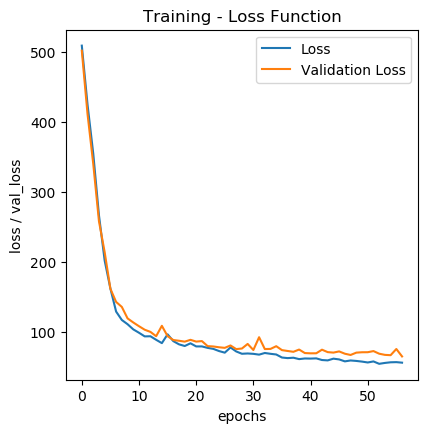

In [477]:
skip=3
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(loss[skip:], label='Loss')
plt.plot(val_loss[skip:], label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss / val_loss')
plt.legend()
plt.title('Training - Loss Function')

In [462]:
# Eventeull weiteres Training

In [478]:
# Trainings- und Testfehler
mse_train = model.evaluate(X_train,y_train)
mse_validate = model.evaluate(X_validate,y_validate)

print('MSE train/val: {:.4f} / {:.4f}'.format(mse_train,mse_validate))
print('RMSE train/val: {:.4f} / {:.4f}'.format(np.sqrt(mse_train),np.sqrt(mse_validate)))

8/8 [==============================] - 0s 6ms/step - loss: 64.7926
MSE train/val: 52.4819 / 64.7926
RMSE train/val: 7.2444 / 8.0494


Text(0.5, 1.0, 'Testset')

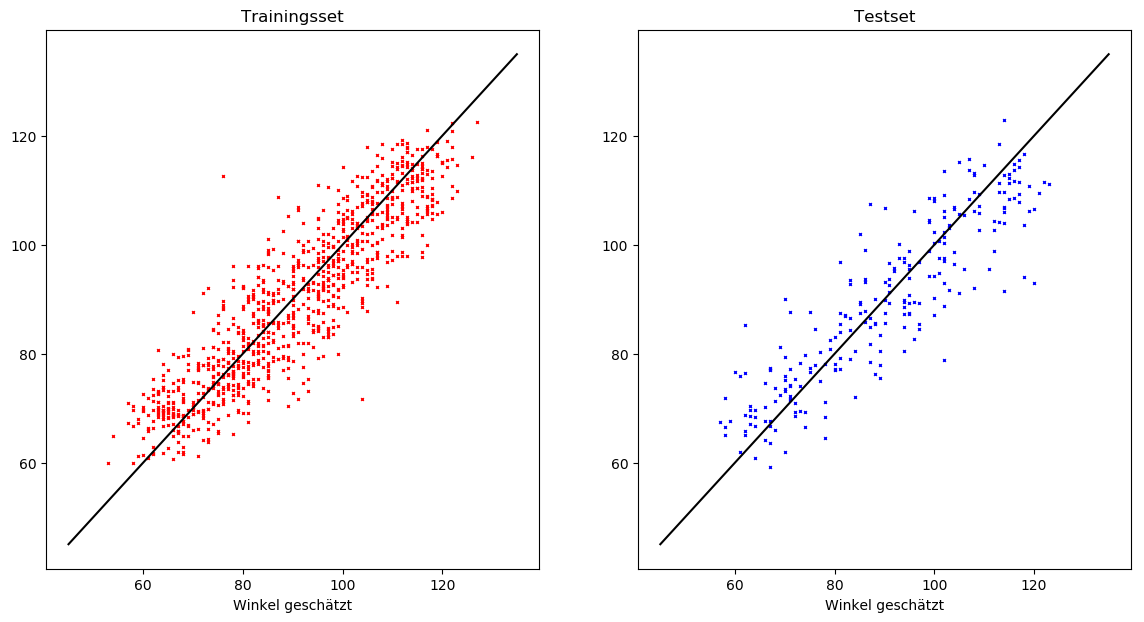

In [479]:
# Visualisierung der Fehler
y_train_p = model.predict(X_train)
y_validate_p = model.predict(X_validate)

plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(y_train,y_train_p,'rx',ms=2)
plt.plot([45,135],[45,135],'k-')
plt.xlabel('Winkel real')
plt.xlabel('Winkel geschätzt')
plt.title('Trainingsset')

plt.subplot(122)
plt.plot(y_validate,y_validate_p,'bx',ms=2)
plt.plot([45,135],[45,135],'k-')
plt.xlabel('Winkel real')
plt.xlabel('Winkel geschätzt')
plt.title('Testset')

In [480]:
# Speichern des trainierten Modells
path_to_model_file = './gitignore/data/model/DEMO_MODEL.h5'# Speichert im H5-Format
# path_to_model_file = './gitignore/data/model/DEMO_MODEL' # Speichert im SavedModel-Format
model.save(path_to_model_file)

## Verwendung eines trainierten Modells

In [481]:
# Laden eines Modells
path_to_model_file = './gitignore/data/model/DEMO_MODEL.h5'
model_loaded = tf.keras.models.load_model(path_to_model_file)

In [482]:
# Informationen über das Netz erhalten
#model_loaded.get_config()

In [483]:
# Shape des Input-Layers
model_loaded.layers[0].input_shape

(None, 20, 64, 1)

In [484]:
mse_train = model_loaded.evaluate(X_train,y_train)
mse_validate = model_loaded.evaluate(X_validate,y_validate)

print('MSE train/val: {:.4f} / {:.4f}'.format(mse_train,mse_validate))
print('RMSE train/val: {:.4f} / {:.4f}'.format(np.sqrt(mse_train),np.sqrt(mse_validate)))

8/8 [==============================] - 0s 8ms/step - loss: 64.7926
MSE train/val: 52.4819 / 64.7926
RMSE train/val: 7.2444 / 8.0494


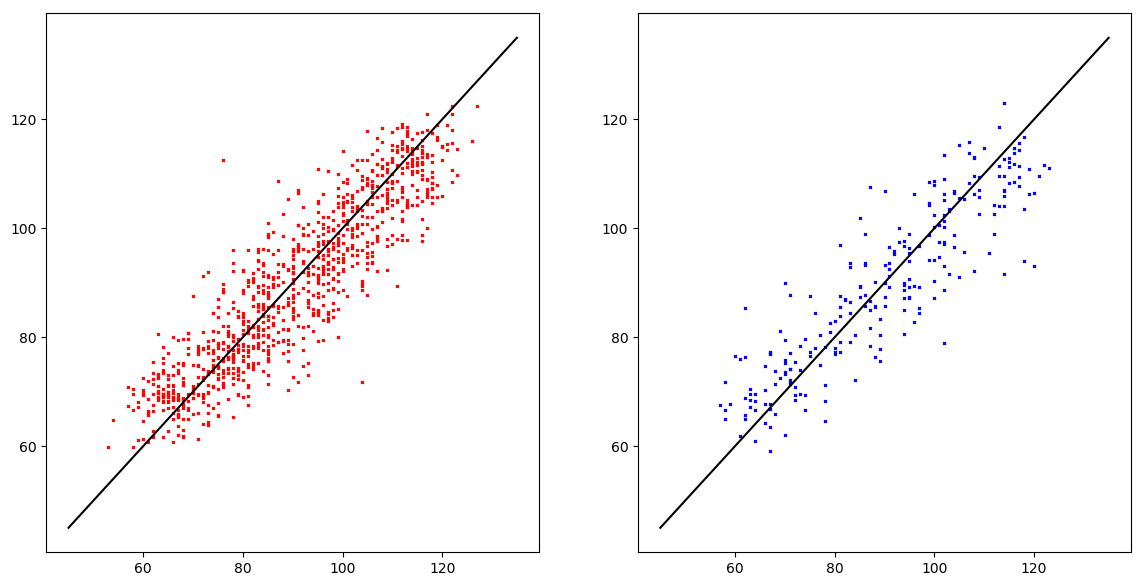

In [485]:
# Visualisierung der Fehler
y_train_p = model_loaded.predict(X_train)
y_validate_p = model_loaded.predict(X_validate)
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(y_train,y_train_p,'rx',ms=2)
plt.plot([45,135],[45,135],'k-')
plt.subplot(122)
plt.plot(y_validate,y_validate_p,'bx',ms=2)
plt.plot([45,135],[45,135],'k-')

### Anwendung des Netzes zur Bestimmung des Lenkwinkels

In [486]:
# Wahl eines Beispielbildes!
xe = np.array( [X_train[0]] )
xe.shape

(1, 20, 64, 1)

In [487]:
# Mittels der Methode predict
model_loaded.predict(xe)

array([[69.8156]], dtype=float32)

In [488]:
# Mittels der Methode __call__ 
model_loaded(xe).numpy()

array([[69.8156]], dtype=float32)

In [489]:
model_loaded.__call__(xe)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[69.8156]], dtype=float32)>

### Ausführungsgeschwindigkeit

In [490]:
# langsam
%timeit model_loaded.predict(xe)

149 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [491]:
# schneller
%timeit model_loaded(xe).numpy()

7.64 ms ± 199 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Model als Tensorflow-lite-Modell speichern

In [ ]:
# Speichern des Modells im TF-eigenen Format
# -> erzeugt Ordner mit Daten des Modells
#path_to_model_tf_format = './gitignore/data/model/DEMO_MODELL_saved_on_RPI'
path_to_model_tf_format = './gitignore/data/model/DEMO_MODELL'
#model.save(path_to_model_tf_format)
#model_loaded.save(path_to_model_tf_format)

In [ ]:
path_to_model_tf_format = './gitignore/data/model/DEMO_MODELL'
converter = tf.lite.TFLiteConverter.from_saved_model(path_to_model_tf_format)
#converter = tf.lite.TFLiteConverter.from_keras_model(model_loaded)

In [ ]:
tflite_model = converter.convert()
# This step fails on my RPI, but works in WinPython. Rob.

In [ ]:
path_to_model_tf_format = './gitignore/data/model/DEMO_MODEL.tflite'
with open(path_to_model_tf_format, 'wb') as f:
    f.write(tflite_model)

In [ ]:
print(angles[0])
plt.imshow(imgs[0],cmap='gray')

In [ ]:
path = './data/some_images_used_by_nb_Using_Tensorflow_lite/'
for i in [1,10,100]:
    name = f"image_{i}_angle_{str(angles[i])}"
    print(name)
    cv2.imwrite(path+name+'.jpg',imgs[i])